In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/iss

/content/gdrive/MyDrive/iss


In [ ]:
!pip install pytorch-transformers

In [ ]:
import pandas as pd
import torch.utils.data as Data
import torch
from pytorch_transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset
import argparse
import os
import copy
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from tqdm.notebook import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 5
SEED = 2021
BERT = 'bert-base-multilingual-cased'
MAX_LENGTH = 220
BATCH_SIZE = 8

In [ ]:
def rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))

In [ ]:
def right_pad(array, n=500):
    current_len = len(array)
    if current_len > n:
        array[n - 1] = 102
        return array[: n]
    extra = n - current_len
    return array + ([0] * extra)

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, x_train, y_train):
        tokenizer = BertTokenizer.from_pretrained(BERT)

        sentences = x_train
        labels = y_train

        self.data = [
            (
                right_pad(
                    tokenizer.encode("[CLS] " + sentence + " [SEP]"), MAX_LENGTH
                    ),
                label,
            )
            for sentence, label in zip(sentences, labels)
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x, y = self.data[index]
        x = torch.tensor(x)
        y = torch.tensor(y, dtype=torch.float)
        return x, y

In [ ]:
class RegressionBert(torch.nn.Module):
    def __init__(self, freeze_bert=True):
        super(RegressionBert, self).__init__()
        self.bert = BertModel.from_pretrained(BERT, num_labels=1)
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False
        self.fc0 = torch.nn.Linear(768, 1)

    def forward(self, x, att=None):
        x = self.bert(x, attention_mask=att)[0]
        x = x[:, 0, :]
        x = self.fc0(x)
        x = x.flatten()
        return x

In [ ]:
def train_one_epoch(model, optimizer, dataset, f_loss, device="cpu"):
    generator = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True
    )
    model.train()
    train_loss, train_acc = 0.0, 0.0
    for batch, labels in tqdm(generator):
        batch, labels = batch.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(batch)
        loss = f_loss(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += rmse(preds.cpu().detach(), labels.cpu().detach())
    train_loss /= len(dataset)
    train_acc /= len(dataset)
    return train_loss, train_acc

In [ ]:
def evaluate_one_epoch(model, dataset, f_loss, device="cpu"):
    generator = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True
    )
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for batch, labels in tqdm(generator):
            batch, labels = batch.to(device), labels.to(device)
            preds = model(batch)
            loss = f_loss(preds, labels)
            val_loss += loss.item()
            preds = preds.cpu().detach()
            val_acc += rmse(preds, labels.cpu().detach())
    val_loss /= len(dataset)
    val_acc /= len(dataset)
    return val_loss, val_acc

In [ ]:
def predict_one_epoch(model, dataset, device="cpu"):
    generator = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch, labels in tqdm(generator):
            batch = batch.to(device)
            preds = model(batch)
            preds = preds.cpu().detach()
            predictions += preds
    return predictions

In [ ]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
    return X_train, X_test, y_train, y_test

In [ ]:
df = pd.read_csv("https://storage.yandexcloud.net/nlp-dataset-bucket-1/toloka-vk-proceedings-2020/toloka-vk-raw-unprocessed.tsv", sep='\t',
                 names=['INPUT:text', 'OUTPUT:disgust_rage', 'OUTPUT:fear_surprise', 'OUTPUT:shame_excitement', 'OUTPUT:enjoyment_distress'],
                 index_col=False, header=0)
df = df.dropna(how='all')
df.head()

,INPUT:text,OUTPUT:disgust_rage,OUTPUT:fear_surprise,OUTPUT:shame_excitement,OUTPUT:enjoyment_distress
0,"Приехала в свой родной город на выходные, от з...",2.0,3.0,0.0,2.0
2,У моей мамы два с половиной года назад отказал...,0.0,-4.0,0.0,5.0
4,Два года назад племянника моего мужа сбила маш...,5.0,-2.0,0.0,5.0
6,"Год без секса, но больше всего скучаю не по фи...",0.0,0.0,4.0,1.0
8,На днях узнала что беременна . Мой жених уходи...,0.0,-5.0,-3.0,3.0


In [ ]:
input_col = 'INPUT:text'
outpul_cols = ['OUTPUT:disgust_rage', 'OUTPUT:fear_surprise', 'OUTPUT:shame_excitement', 'OUTPUT:enjoyment_distress']

In [ ]:
df[outpul_cols].values

array([[ 2.,  3.,  0.,  2.],
       [ 0., -4.,  0.,  5.],
       [ 5., -2.,  0.,  5.],
       ...,
       [ 0.,  0.,  0.,  4.],
       [-1., -3., -2.,  4.],
       [-5.,  2., -3.,  3.]])

In [ ]:
df.shape

(3965, 5)

In [ ]:
y = df['OUTPUT:disgust_rage'].values
X = df[input_col]

X_train, X_test, y_train, y_test = split_data(X, y)
X_train, X_val, y_train, y_val = split_data(X_train, y_train)

X_train = X_train.values
X_test = X_test.values
X_val = X_val.values

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def start_work(old_model=None):

    freeze_bert = False
    
    train_stats = []
    val_stats = []

    train_set = CustomDataset(X_train, y_train)
    val_set = CustomDataset(X_val, y_val)
    test_set = CustomDataset(X_test, np.zeros([X_test.shape[0]]))

    model = RegressionBert(freeze_bert).to(device)
    if old_model is not None and os.path.exists(old_model):
        model.load_state_dict(torch.load(old_model))
        print("Model loaded")
    

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    f_loss = torch.nn.MSELoss()

    best_model = copy.deepcopy(model.state_dict())
    best_val_loss = np.inf

    print("Start training...")
    for epoch in range(0, EPOCHS):

        train_loss, train_acc = train_one_epoch(model, optimizer, train_set, f_loss, device)
        print("Epoch {}, Train loss: {}, Train RMSE: {}".format(epoch + 1, train_loss, train_acc))

        val_loss, val_acc = evaluate_one_epoch(model, val_set, f_loss, device)
        print("Epoch {}, Val loss: {}, Val RMSE: {}".format(epoch + 1, val_loss, val_acc))

        train_stats.append((train_loss, train_acc))
        val_stats.append((val_loss, val_acc))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
    print("Finish training")

    model.load_state_dict(best_model)
    print("Loaded best model")
    
    print("Making predictions...")
    predictions = predict_one_epoch(model, test_set, device)
    predictions = predictions[:X_test.shape[0]]
    predictions = np.array(predictions)

    pd.DataFrame(predictions).to_csv(f"results_{datetime.now()}.csv", index=False, header=False)
    print("Predictions saved")
    
    torch.save(model.state_dict(), f"bert_mlingual_model_{datetime.now()}.pth")
    print("Model saved")
    return train_stats, val_stats, pd.DataFrame(predictions)

In [ ]:
%%time
train_stats1, val_stats1, preds1 = start_work()

Token indices sequence length is longer than the specified maximum sequence length for this model (595 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Start training...



Epoch 1, Train loss: 0.7120935076082281, Train RMSE: 0.2861784424377606



Epoch 1, Val loss: 0.7146194010507875, Val RMSE: 0.28478026307420407



Epoch 2, Train loss: 0.6660572430608078, Train RMSE: 0.27469905373245107



Epoch 2, Val loss: 0.6653332209386745, Val RMSE: 0.27291502979337307



Epoch 3, Train loss: 0.5995407540094103, Train RMSE: 0.2614616754334425



Epoch 3, Val loss: 0.6583851130068803, Val RMSE: 0.27465703594075097



Epoch 4, Train loss: 0.49128650848578226, Train RMSE: 0.23812250017589967



Epoch 4, Val loss: 0.8001322810675632, Val RMSE: 0.30679756564589944



Epoch 5, Train loss: 0.3835340141022365, Train RMSE: 0.20959847319969002



Epoch 5, Val loss: 0.8042603060692585, Val RMSE: 0.30447170305334925
Finish training
Loaded best model
Making predictions...



Predictions saved
Model saved
CPU times: user 5min 54s, sys: 4min 12s, total: 10min 7s
Wall time: 10min 22s


In [ ]:
rmse(preds1, y_test)

2.2507136920855784

In [ ]:
preds1

,0
0,0.612651
1,0.361835
2,-0.304830
3,0.344872
4,-0.624707
...,...
1185,1.147769
1186,-0.051608
1187,0.369126
1188,-0.465304


In [ ]:
def plot_target(y_train, y_test, label_1='y_train', label_2='y_test'):
    fig, ax = plt.subplots()
    pd.DataFrame(y_train).hist(ax=ax, bins=100)
    y_test.hist(ax=ax, bins=100)
    ax.set_yscale('log')
    ax.legend([label_1, label_2])

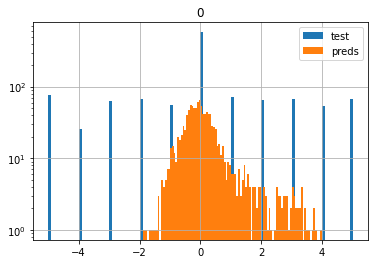

In [ ]:
plot_target(y_test, preds1, 'test', 'preds')

In [ ]:
train_rmse = [item[1] for item in train_stats1]
val_rmse = [item[1] for item in val_stats1]

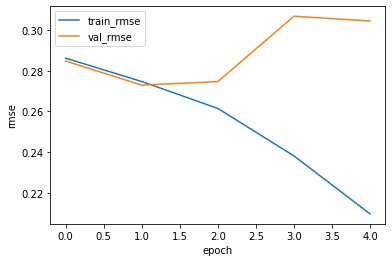

In [ ]:
plt.plot(train_rmse)
plt.plot(val_rmse)
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train_rmse', 'val_rmse'], loc='upper left')
plt.show()